In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures
import math
# 評価関数（f1_score）
from sklearn.metrics import f1_score 
# 混同行列
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

## 訓練データの読み込み

In [3]:
class TrainDataset(Dataset):
    def __init__(self):
        super().__init__()
        # CSVファイル読み込み（訓練データ）
        self.df = pd.read_csv('train.csv')
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        self.df = self.correction(self.df)
        
        # 説明変数と目的変数に分割する
        df_x = self.df.drop(['loan_status'], axis=1)
        self.df_y = self.df.loc[:,['loan_status']]
        self.targetConv()
        
        # 説明変数の量的データ、質的データ分割
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df_x.copy())
        self.x_desc = self.x_cont.describe()
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        #self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        self.logFlg = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.X_train)
        self.num = len(self.X_train_cate)
        
    def __getitem__(self, index):
        return self.X_train_cate[index], self.X_train_cont[index], self.Y_train[index]
    
    def __len__(self):
        return self.num
    
    def correction(self, df):
        
        print('null check')
        print(df.isnull().sum())
        print('-------------------------')
        
        return df
    
    def viewDescribe(self):
        self.x_cont.describe()
        self.x_cate.describe(include='O')
    
    def dropCol(self):
        
        #self.x_cate_conv = self.x_cate_conv.drop(columns=['employment_length'], axis=1)
        self.x_cate_conv = self.x_cate_conv.drop(columns=['employment_length','application_type' , 'term'], axis=1)
        # application_type  は使ってみる
        
        
        #self.x_cont_conv = self.x_cont_conv.drop(columns=['loan_amnt'], axis=1)
        self.x_cont_conv = self.x_cont_conv.drop(columns=['loan_amnt','credit_score'], axis=1)
        # credit_score  は使ってみる（差があるかは要確認）
        
    def DataChange(self, df_x):
        categ_cols = ['term' ,'grade' ,'employment_length', 'purpose' ,'application_type']
        contin_cols = ['loan_amnt', 'interest_rate', 'credit_score']
        index_cols = ['id']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()
        x_id = df_x[index_cols].copy()
        x_id = x_id.astype('int64')
        
        return x_cate , x_cont  ,x_id
    
    def targetConv(self):
        self.df_y = self.df_y.replace('FullyPaid', '0').replace('ChargedOff', '1')
        self.df_y.astype('float32')
        
    def NpToPy(self):
        
        #tmp = self.x_cont[['displacement_log', 'horsepower_log', 'weight_log', 'acceleration_log']]
        #tmp = self.x_cont[['horsepower_log', 'weight_log', 'acceleration_log']]

        # 訓練データと検証データに分割
        x_train_cate, x_test_cate ,y_train, y_test = train_test_split(self.x_cate_conv, self.df_y, test_size=0.2, random_state=3) 
        
        # カテゴリデータと同じ行数分数値データを抽出する
        ### 訓練データ
        row_index = x_train_cate.index.values
        x_train_cont = self.x_cont_conv.loc[row_index, :]
        self.X_train_id = self.x_id.loc[row_index, :]
        self.X_train_id.reset_index(drop=True, inplace=True)
        
        ### 検証データ
        row_index = x_test_cate.index.values
        x_test_cont = self.x_cont_conv.loc[row_index, :]
        self.X_test_id = self.x_id.loc[row_index, :]
        self.X_test_id.reset_index(drop=True, inplace=True)
        
        # pandas.DataFrame を numpyに変換する
        x_train_cate = np.array(x_train_cate, dtype=np.float64)
        x_test_cate = np.array(x_test_cate, dtype=np.float64)
        x_train_cont = np.array(x_train_cont, dtype=np.float64)
        x_test_cont = np.array(x_test_cont, dtype=np.float64)
        y_train = np.array(y_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        
        
        # numpy の値を torch の値に変換する
        self.X_train_cate = torch.from_numpy(x_train_cate).float()
        self.X_train_cont = torch.from_numpy(x_train_cont).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.X_test_cate = torch.from_numpy(x_test_cate).float()
        self.X_test_cont = torch.from_numpy(x_test_cont).float()
        self.Y_test = torch.from_numpy(y_test).float()
        
        # 列数
        self.coti_size = self.X_train_cont.shape[1]
        self.cate_size  = self.X_train_cate.shape[1]
        self.in_size  = self.coti_size + self.cate_size
        self.out_size = self.Y_train.shape[1]  

        
    def termConv(self):
        
        col = 'term'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='3 years']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロが5 yearsなので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='5 years']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def gradeConv(self):
        
        col = 'grade'
        

        
        grade = 'A1'
        ren = '01'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0

        grade = 'A2'
        ren = '02'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        grade = 'A3'
        ren = '03'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        grade = 'A4'
        ren = '04'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0

        grade = 'A5'
        ren = '05'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0

        
        grade = 'B1'
        ren = '06'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0

        #row_index = self.x_cate[(self.x_cate[col]=='B1') & (self.x_cate['purpose'] == 'home_improvement') & (self.x_cate['term'] == '5 years')].index
        #self.x_cate_conv.loc[row_index, col + '_06_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_06'] = 0
        
          
        grade = 'B2'
        ren = '07'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation')  & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') & (self.x_cont['interest_rate'] > 10) ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        ###  70～80
        #row_index = self.x_cate[(self.x_cate[col]=='B2') & (self.x_cate['purpose'] == 'medical')].index
        #self.x_cate_conv.loc[row_index, col + '_07_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_07'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='B2') & (self.x_cate['purpose'] == 'small_business')].index
        #self.x_cate_conv.loc[row_index, col + '_07_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_07'] = 0
        
        
        grade = 'B3'
        ren = '08'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'B4'
        ren = '09'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'B5'
        ren = '10'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'C1'
        ren = '11'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'C2'
        ren = '12'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        

        #row_index = self.x_cate[(self.x_cate[col]=='C2') & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'home_improvement') ].index
        #self.x_cate_conv.loc[row_index, col + '_12_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_12'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='C2') & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'other') ].index
        #self.x_cate_conv.loc[row_index, col + '_12_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_12'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='C2') & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'medical') ].index
        #self.x_cate_conv.loc[row_index, col + '_12_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_12'] = 0
        
        
        
        grade = 'C3'
        ren = '13'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        #row_index = self.x_cate[(self.x_cate[col]=='C3') & (self.x_cate['purpose'] == 'medical') ].index
        #self.x_cate_conv.loc[row_index, col + '_13_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_13'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='C3') & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'major_purchase') ].index
        #self.x_cate_conv.loc[row_index, col + '_13_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_13'] = 0
        
        
        grade = 'C4'
        ren = '14'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'C5'
        ren = '15'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        #row_index = self.x_cate[(self.x_cate[col]=='C5')  & (self.x_cate['purpose'] == 'home_improvement') ].index
        #self.x_cate_conv.loc[row_index, col + '_15_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_15'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='C5') & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'car') ].index
        #self.x_cate_conv.loc[row_index, col + '_15_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_15'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='C5')  & (self.x_cate['purpose'] == 'major_purchase') ].index
        #self.x_cate_conv.loc[row_index, col + '_15_2'] = 1
        #self.x_cate_conv.loc[row_index, col + '_15'] = 0
        
        
        
        grade = 'D1'
        ren = '16'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        #row_index = self.x_cate[(self.x_cate[col]=='D1')  & (self.x_cate['purpose'] == 'car') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='D1') & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'home_improvement') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='D1') & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'other') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0

        
        grade = 'D2'
        ren = '17'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'D3'
        ren = '18'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'D4'
        ren = '19'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'D5'
        ren = '20'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'E1'
        ren = '21'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        #row_index = self.x_cate[(self.x_cate[col]=='D1')  & (self.x_cate['purpose'] == 'car') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='D1') & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'home_improvement') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0
        #row_index = self.x_cate[(self.x_cate[col]=='D1') & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'other') ].index
        #self.x_cate_conv.loc[row_index, col + '_16_1'] = 1
        #self.x_cate_conv.loc[row_index, col + '_16'] = 0

        
        grade = 'E2'
        ren = '22'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'E3'
        ren = '23'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'E4'
        ren = '24'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        
        
        grade = 'E5'
        ren = '25'
        self.x_cate_conv[col + '_' + ren + '_1'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_2'] = 0
        self.x_cate_conv[col + '_' + ren + '_3'] = 0
        self.x_cate_conv[col + '_' + ren + '_4'] = 0
        self.x_cate_conv[col + '_' + ren + '_5'] = 0
        self.x_cate_conv[col + '_' + ren + '_6'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 1
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_3'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '3 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_4'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_1'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'debt_consolidation') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_5'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0
        row_index = self.x_cate[(self.x_cate[col]==grade) & (self.x_cate['term'] == '5 years')  & (self.x_cate['purpose'] == 'credit_card') ].index
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_6'] = 1
        self.x_cate_conv.loc[row_index, col + '_' + ren + '_2'] = 0

        
        grade = 'F1'
        ren = '26'
        self.x_cate_conv[col + '_' + ren] = 0
        row_index = self.x_cate.index[self.x_cate[col]==grade]
        self.x_cate_conv.loc[row_index, col + '_' + ren] = 1
        grade = 'F2'
        ren = '27'
        self.x_cate_conv[col + '_' + ren] = 0
        row_index = self.x_cate.index[self.x_cate[col]==grade]
        self.x_cate_conv.loc[row_index, col + '_' + ren] = 1
        grade = 'F3'
        ren = '28'
        self.x_cate_conv[col + '_' + ren] = 0
        row_index = self.x_cate.index[self.x_cate[col]==grade]
        self.x_cate_conv.loc[row_index, col + '_' + ren] = 1
        grade = 'F4'
        ren = '29'
        self.x_cate_conv[col + '_' + ren] = 0
        row_index = self.x_cate.index[self.x_cate[col]==grade]
        self.x_cate_conv.loc[row_index, col + '_' + ren] = 1
        grade = 'F5'
        
        row_index = self.x_cate.index[self.x_cate[col]==grade]
        #self.x_cate_conv.loc[row_index, col + '_04'] = 1
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
        
    def purposeConv(self):
        
        col = 'purpose'
        
        self.x_cate_conv[col + '_1'] = 0
        self.x_cate_conv[col + '_2'] = 0
        self.x_cate_conv[col + '_3'] = 0
        self.x_cate_conv[col + '_4'] = 0
        self.x_cate_conv[col + '_5'] = 0
        self.x_cate_conv[col + '_6'] = 0 
        #self.x_cate_conv[col + '_7'] = 0
        #self.x_cate_conv[col + '_8'] = 0
        
        row_index = self.x_cate.index[self.x_cate[col]=='car']
        self.x_cate_conv.loc[row_index, col + '_2'] = 1
        
        #row_index = self.x_cate.index[self.x_cate[col]=='credit_card']
        #self.x_cate_conv.loc[row_index, col + '_2'] = 1
        
        #row_index = self.x_cate.index[self.x_cate[col]=='debt_consolidation']
        #self.x_cate_conv.loc[row_index, col + '_2'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='home_improvement']
        self.x_cate_conv.loc[row_index, col + '_2'] = 1
        
        #row_index = self.x_cate.index[self.x_cate[col]=='house']
        #self.x_cate_conv.loc[row_index, col + '_3'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='major_purchase']
        self.x_cate_conv.loc[row_index, col + '_3'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='medical']
        self.x_cate_conv.loc[row_index, col + '_4'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='small_business']
        self.x_cate_conv.loc[row_index, col + '_5'] = 1
        
        
        row_index = self.x_cate.index[self.x_cate[col]=='other']
        self.x_cate_conv.loc[row_index, col + '_6'] = 1
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        

    def appConv(self):
        
        col = 'application_type'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='Individual']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロがJoint Appなので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='Joint App']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
    def addCol(self):
        
        col = 'special'

        self.x_cate_conv[col + '_x1'] = 0
        row_index = self.x_cate.index[ (self.x_cont['credit_score'] > 700) & (self.x_cont['credit_score'] <= 740) ]
        self.x_cate_conv.loc[row_index, col + '_x1'] = 1
        
        
        self.x_cate_conv[col + '_x2'] = 0
        row_index = self.x_cate.index[self.x_cont['credit_score'] > 740]
        self.x_cate_conv.loc[row_index, col + '_x2'] = 1
        
        
        self.x_cate_conv[col + '_x3'] = 0
        row_index = self.x_cate.index[(self.x_cont['interest_rate'] <= 10) ]
        self.x_cate_conv.loc[row_index, col + '_x3'] = 1
        
        
        self.x_cate_conv[col + '_x4'] = 0
        row_index = self.x_cate.index[(self.x_cont['interest_rate'] > 10) & (self.x_cont['interest_rate'] <= 15) ]
        self.x_cate_conv.loc[row_index, col + '_x4'] = 1
        
        
        self.x_cate_conv[col + '_x5'] = 0
        row_index = self.x_cate.index[(self.x_cont['interest_rate'] > 15)  & (self.x_cont['interest_rate'] <=20) ]
        self.x_cate_conv.loc[row_index, col + '_x5'] = 1
        
        
        self.x_cate_conv[col + '_x6'] = 0
        row_index = self.x_cate.index[(self.x_cont['interest_rate'] > 20) ]
        self.x_cate_conv.loc[row_index, col + '_x6'] = 1
        
        
    def binSplit(self):
        contin_cols = self.x_cont_conv.columns.values

        for col in contin_cols:
            split_min = 0
            split_min2 = self.x_desc.loc['min',col]
            split1 = self.x_desc.loc['25%',col]
            split2 = self.x_desc.loc['50%',col]
            split3 = self.x_desc.loc['75%',col]
            std_m = self.x_desc.loc['std',col]/3
            std_p = self.x_desc.loc['std',col]*3
            split_max=  self.x_desc.loc['max',col]
            split_max2=  self.x_desc.loc['max',col]*10
            bins = [split_min,  split_min2, split1,  split2,  split3, std_m,  std_p,  split_max, split_max2]
            bins = np.sort(bins)
            self.x_cont_conv[col] = pd.cut(self.x_cont_conv[col], bins=bins, labels=False)
    
    def rateRound(self):
        col = 'interest_rate'
        self.x_cont_conv[col] = round(self.x_cont_conv[col] , 1)
    
    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        tmp_x = pd.concat([self.x_cont_conv , self.x_cate_conv] , axis=1)
        tmp_y = np.array(self.df_y , dtype=np.int32)
        tmp_y = pd.DataFrame(tmp_y, columns=['loan_status'])
        df_sns = pd.concat([tmp_x , tmp_y] , axis=1)
        #print(df_sns.corr())
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()
            
    def binSplit2(self):
        contin_cols = self.x_cont_conv.columns.values

        for col in contin_cols:
            
            bins = 30
            self.x_cont_conv[col] = pd.cut(self.x_cont_conv[col], bins=bins ,labels=False)
            
    def DataConv(self):

        self.addCol()
        #self.termConv()
        self.gradeConv()
        self.purposeConv()
        #self.appConv()
        #self.binSplit2()
        self.rateRound()
        self.dropCol()        
        self.NpToPy()
        

In [4]:
train_dataset = TrainDataset()

null check
id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
loan_status          0
dtype: int64
-------------------------


In [40]:
train_dataset.coti_size

1

In [5]:
class TestDataset(TrainDataset):
    def __init__(self, x_desc):
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('test.csv' )
        self.df_data = df.copy()
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        df = self.correction(df)
        
        # 目的変数の格納
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df.copy())
        self.x_desc = x_desc
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        #self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        self.logFlg  = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.x_cate)
        self.num = len(self.x_cate_conv)
        self.coti_size = self.x_cont_conv.shape[1]

    def __getitem__(self, index):
        return self.X_vat[index]
    
    def __len__(self):
        return self.num
    
    def NpToPy(self):
        
        #x_temp = self.x_cont.copy()
        tmp_cate = np.array(self.x_cate_conv)
        tmp_cont = np.array(self.x_cont_conv)
        
        # numpy の値を torch の値に変換する
        self.X_vat_cate = torch.from_numpy(tmp_cate).float()
        self.X_vat_cont = torch.from_numpy(tmp_cont).float()
 


## 評価データの読み込み

In [6]:
test_dataset = TestDataset(train_dataset.x_desc)

null check
id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
dtype: int64
-------------------------


In [7]:
test_dataset.x_cont.describe()

,loan_amnt,interest_rate,credit_score
count,26900.000000,26900.000000,26900.000000
mean,1515.095458,13.778459,683.840319
std,827.710449,4.587711,29.685781
min,353.090088,5.745858,655.435675
25%,753.766957,10.846102,659.589762
50%,1213.754480,13.551492,678.707870
75%,2147.699462,17.128929,698.684676
max,3812.969623,27.503147,811.676356


In [8]:
len(train_dataset)

193720

In [9]:
train_dataset.in_size

167

# モデル定義（分類）

In [41]:
def classification(x ,threshold):
    #print(len(x))
    
    if (x.ndim == 1)and (len(x) == 1):
        if x >= threshold:
            return 1
        else:
            return 0
    else:
        tmp = np.zeros(len(x) ,dtype=np.int32)
        for i in range(len(x)):
            if x[i] >= threshold:
                tmp[i] = 1
            
        return tmp


In [42]:
batchsize=1000

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [43]:
node1=120
node2=80
node3=10


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net1(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net1 ,self).__init__()
        # ドロップアウト
        p=0.5
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        self.dropout3 = nn.Dropout(p)
        
        # バッチ正規化
        self.bn_cont = nn.BatchNorm1d(train_dataset.coti_size)
        
        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size - 1 , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2 , node3)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc4 = nn.Linear(node3,  train_dataset.out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x_cate, x_cont):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る

        # バッチ正規化
        #x_cont = self.bn_cont(x_cont)
        #x = torch.cat([x_cate, x_cont], 1)
        x = x_cate
        
        x = torch.relu (self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))           # 中間層（２階層目）の結果を出力層に渡す
        return x

In [44]:
# モデルの定義
model1 = Net1()
# 損失の定義
criterion1 = nn.BCELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer1 = optim.Adam(model1.parameters() , lr=0.005)

In [45]:
loss_list1 = []
accuracy_list1 = []

correct_counter1 = 0
logdisp=1
#acccnt=len(train_dataset)*logdisp
acccnt=batchsize*logdisp
print('rec_cnt', acccnt)
epochs=50
mathcnt = 0

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss1 = 0
    
    for x_train_cate, x_train_cont, y_train in train_loader:

        # 出力を計算する 
        output1 = model1(x_train_cate, x_train_cont)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss1 = criterion1(output1 ,y_train)
        
        correct_temp = f1_score(y_train.detach().numpy(), classification(output1.detach().numpy() , 0.23))
        correct_counter1 += correct_temp
        mathcnt += 1
        
        # パラメータの勾配を初期化する
        optimizer1.zero_grad()
        # ロスを伝播する
        loss1.backward()
        # パラメータを更新する
        optimizer1.step()

        # トータルロスを格納
        total_loss1 += loss1.item()

    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp1=total_loss1/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\taccu:\t{correct_counter1/mathcnt:.4f}')
        
        
        accuracy_list1.append(correct_counter1.item()/(mathcnt))
        loss_list1.append(loss_tmp1)
        total_loss=0
        correct_counter1 = 0
        mathcnt = 0
        

rec_cnt 1000
Epoch	1	Loss	0.09148981	accu:	0.3140
Epoch	2	Loss	0.08537383	accu:	0.3546
Epoch	3	Loss	0.08438094	accu:	0.3587
Epoch	4	Loss	0.08384667	accu:	0.3657
Epoch	5	Loss	0.08351805	accu:	0.3702
Epoch	6	Loss	0.08333689	accu:	0.3752
Epoch	7	Loss	0.08329015	accu:	0.3748
Epoch	8	Loss	0.08319009	accu:	0.3773
Epoch	9	Loss	0.08320866	accu:	0.3770
Epoch	10	Loss	0.08310799	accu:	0.3774
Epoch	11	Loss	0.08311970	accu:	0.3783
Epoch	12	Loss	0.08312644	accu:	0.3762
Epoch	13	Loss	0.08326990	accu:	0.3778
Epoch	14	Loss	0.08317205	accu:	0.3806
Epoch	15	Loss	0.08315257	accu:	0.3782
Epoch	16	Loss	0.08308641	accu:	0.3784
Epoch	17	Loss	0.08310111	accu:	0.3801
Epoch	18	Loss	0.08308541	accu:	0.3792
Epoch	19	Loss	0.08311710	accu:	0.3801
Epoch	20	Loss	0.08304771	accu:	0.3823
Epoch	21	Loss	0.08301346	accu:	0.3801
Epoch	22	Loss	0.08301307	accu:	0.3817
Epoch	23	Loss	0.08295276	accu:	0.3821
Epoch	24	Loss	0.08300597	accu:	0.3821
Epoch	25	Loss	0.08302730	accu:	0.3815
Epoch	26	Loss	0.08307970	accu:	0.3811
Epoch	27

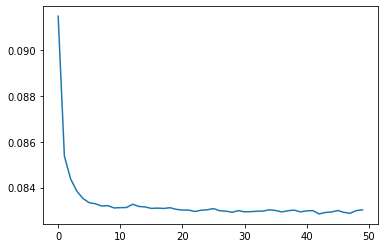

In [46]:
# ロスのプロット
plt.plot(loss_list1)

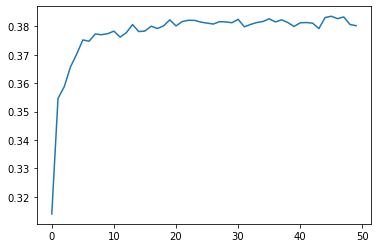

In [47]:
plt.plot(accuracy_list1)

# 予測精度の確認

## 訓練データ 

In [48]:
# 学習を行わないモードに変更
model1.eval()

Net1(
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=166, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
y_pred_train=model1(train_dataset.X_train_cate, train_dataset.X_train_cont).data
df_pred_train = pd.DataFrame(y_pred_train.numpy() , columns=['vat'])
df_pred_train = pd.concat([train_dataset.X_train_id , df_pred_train] , axis=1)
print(df_pred_train)


            id       vat
0       142857  0.139226
1       150352  0.140000
2        88069  0.132645
3       223288  0.137456
4       210164  0.142216
...        ...       ...
193715   48056  0.149166
193716  190083  0.159473
193717   77049  0.137431
193718  198296  0.179510
193719   71530  0.222328

[193720 rows x 2 columns]


In [50]:

# 予測結果から閾値の算出
chargedoff_val = train_dataset.Y_train.sum()
chargedoff_val = int(chargedoff_val)
proba_desc = df_pred_train.loc[:,'vat'].sort_values(ascending = False)
threshold = proba_desc.iat[chargedoff_val]
print(threshold)


0.25655746


In [51]:
threshold=0.17

In [52]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.38899934282220433


In [53]:
threshold=0.18

In [54]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.3913552684551476


In [55]:
threshold=0.19

In [56]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.39293567344980607


In [57]:
threshold=0.20

In [58]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.3927807046427395


In [59]:
threshold=0.21

In [60]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.3917738774814689


In [61]:
threshold=0.22

In [62]:
pred_tmp = classification(y_pred_train.numpy() ,threshold)
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.39100057410877737


In [63]:
threshold=0.20
pred_tmp = classification(y_pred_train.numpy() ,threshold)

In [64]:
# 混同行列
confusion_matrix(train_dataset.Y_train, pred_tmp)

array([[115622,  44187],
       [ 14825,  19086]], dtype=int64)

In [65]:
print(classification_report(train_dataset.Y_train, pred_tmp))

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80    159809
         1.0       0.30      0.56      0.39     33911

    accuracy                           0.70    193720
   macro avg       0.59      0.64      0.59    193720
weighted avg       0.78      0.70      0.73    193720



## 検証データ

In [66]:
y_pred_test=model1(train_dataset.X_test_cate, train_dataset.X_test_cont).data
df_pred_test = pd.DataFrame(y_pred_test.numpy() ,columns=['vat'])
df_pred_test = pd.concat([train_dataset.X_test_id , df_pred_test] , axis=1)
print(df_pred_test)


           id       vat
0      169435  0.430127
1      216164  0.243647
2      158682  0.143806
3      121892  0.025719
4       85644  0.133969
...       ...       ...
48425   27757  0.159473
48426  215081  0.261852
48427  163023  0.129848
48428   72738  0.132645
48429  142864  0.288271

[48430 rows x 2 columns]


In [67]:
pred_tmp = classification(np.array(df_pred_test.loc[:,'vat']) ,threshold)
score_test = f1_score(train_dataset.Y_test, pred_tmp)
# f1_scoreの表示
print(score_test)

0.38228418767740857


In [68]:
# 混同行列
confusion_matrix(train_dataset.Y_test, pred_tmp)

array([[29053, 10932],
       [ 3866,  4579]], dtype=int64)

In [69]:
print(classification_report(train_dataset.Y_test, pred_tmp))

              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80     39985
         1.0       0.30      0.54      0.38      8445

    accuracy                           0.69     48430
   macro avg       0.59      0.63      0.59     48430
weighted avg       0.78      0.69      0.72     48430



# 予測結果から予測を外す対象の分析

In [76]:
df_pred_train['train'] = 1
df_pred_test['train'] = 0

tmp = pd.concat([df_pred_train  ,df_pred_test] )
#tmp = tmp.drop(columns=['capa', 'vat_tmp'] , axis=1)

data = pd.merge(train_dataset.df, tmp , on='id' , how='left')
data['bat_val'] =  classification(np.array(tmp['vat']) ,threshold)
data['loan_status_val'] = data['loan_status'].replace('FullyPaid', '0').replace('ChargedOff', '1')

data.head()


,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status,vat,train,bat_val,loan_status_val
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid,0.025739,1,0,0
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff,0.176482,1,0,1
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid,0.159473,1,0,0
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid,0.142216,1,0,0
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid,0.402702,1,0,0


In [77]:
values1 = ['1']
values0 = ['0']
col = 'employment_length'
## 全件
#tmp = data.loc[data.index[data['bat_val'].isin([1]),col]
tmp1 = data.loc[(data.index[data['bat_val'].isin(values1)]) & (data.index[data['loan_status_val'].isin(values0)]) ,:].copy()
tmp1['FalseToTrue'] = 1
tmp1[col].value_counts()

10 years    27424
0 years      5022
9 years      4833
1 year       4168
2 years      4107
6 years      4004
4 years      3892
7 years      3554
5 years      3516
3 years      3100
8 years      1334
Name: employment_length, dtype: int64

In [78]:
tmp2 = data.loc[(data.index[data['bat_val'].isin(values0)]) & (data.index[data['loan_status_val'].isin(values1)]) ,:].copy()
tmp2['FalseToTrue'] = 0
tmp2[col].value_counts()

10 years    12876
0 years      2681
9 years      2294
2 years      2048
1 year       1583
6 years      1500
5 years      1369
3 years      1307
7 years      1200
4 years      1035
8 years       633
Name: employment_length, dtype: int64

In [79]:
print(len(tmp1) + len(tmp2))

93480


In [80]:
tmp_err = pd.concat([tmp1 , tmp2])
group = tmp_err.groupby(['grade', 'employment_length' , 'term', 'purpose', 'FalseToTrue'])['bat_val'].count()
group.name='count'


In [81]:
tmp_err.to_csv('./err.csv', encoding='utf_8_sig' )

#  予測する

In [46]:
y_predict=model1(test_dataset.X_vat_cate, test_dataset.X_vat_cont).data
df_predict = pd.DataFrame(y_predict.numpy())
y_predict = classification(np.array(df_predict[0]) ,threshold)

df_out = pd.DataFrame(y_predict, columns=['val'])
df_out = pd.concat([test_dataset.x_id['id'] ,df_out['val']] , axis=1)
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False ,index=False)
df_out




,id,val
0,242150,0
1,242151,1
2,242152,0
3,242153,0
4,242154,0
...,...,...
26895,269045,0
26896,269046,0
26897,269047,0
26898,269048,0


# モデルの保存

In [48]:
#model_path = 'model1.pth'
#torch.save(model1.to('cpu').state_dict(), model_path)
